In [14]:
# Libraries Load
#

import os

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.api import OLS, add_constant


import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
from pandas.plotting import lag_plot


# Various Utility Functions

In [2]:
# A simple utility function to obtain and summarise key elements of a given dataframe
#

def print_file_summary(data_frame):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniqueness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate data types 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'List': 0
                                 })
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()

    display(summary_of_df)

In [3]:
# Function to decompose a daily time series
#

def decompose_time_series(df):
    # Perform decomposition
    decomposition = seasonal_decompose(df['Value'], model='additive', period=365)

    # Plot the decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 8), sharex=True)

    ax1.set_title('Observed', fontsize=12)
    ax1.plot(decomposition.observed, label='Observed')
    ax2.set_title('Trend', fontsize=12)
    ax2.plot(decomposition.trend, label='Trend', color='orange')
    ax3.set_title('Seasonal', fontsize=12)
    ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
    ax4.set_title('Residuals', fontsize=12)
    #ax4.plot(decomposition.resid, label='Residuals', color='red')
    ax4.scatter(decomposition.resid.index, decomposition.resid, label='Residuals', color='red', s=10)

    plt.show()

# Examine Autocorrelation & Seasonality

Summary of Time Series - CSV


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
Value,1827,0,0,1821,float64,0,0,1827,0


First 3 rows


,Value
Date,
2020-01-01,26.919247
2020-01-02,26.106924
2020-01-03,25.267577


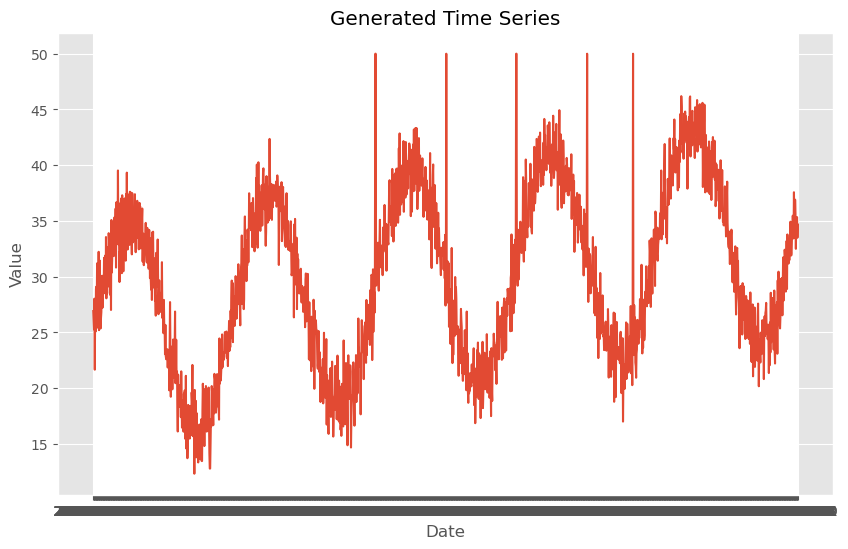

In [4]:
# Load csv files into Pandas Dataframes

DATA_DIRECTORY = 'Data_Sources'
DATA_FILENAME = 'test_timeseries.csv'
parent_path = os.path.dirname(os.getcwd())

data_file_path = os.path.join(parent_path, DATA_DIRECTORY, DATA_FILENAME)      
if not os.path.isfile(data_file_path):
    raise Exception(f'File not found: {data_file_path}')
test_df = pd.read_csv(data_file_path)
test_df.set_index('Date', inplace=True)

# Initial look at the file and data fields
print(f'Summary of Time Series - CSV')
print_file_summary(test_df)
print(f'First 3 rows')
display(test_df.head(3))

# Plot the sample
fig, ax = plt.subplots()
ax.set_title(f'Generated Time Series')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.plot(test_df.index, test_df['Value'])
plt.show()


- do some residual, lag plots etc, identify autocorrelation, decompositions, ADF tests etc
- Plots: residuals, lag plots etc
- Decompositions 

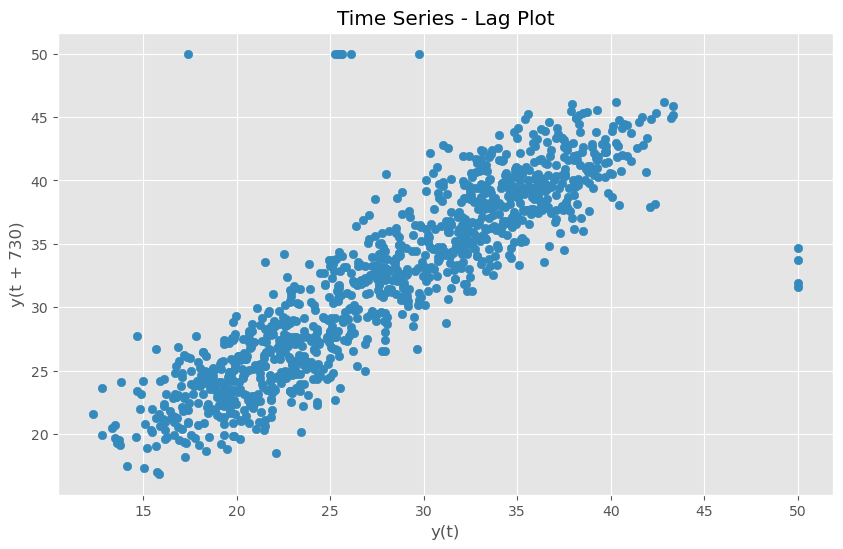

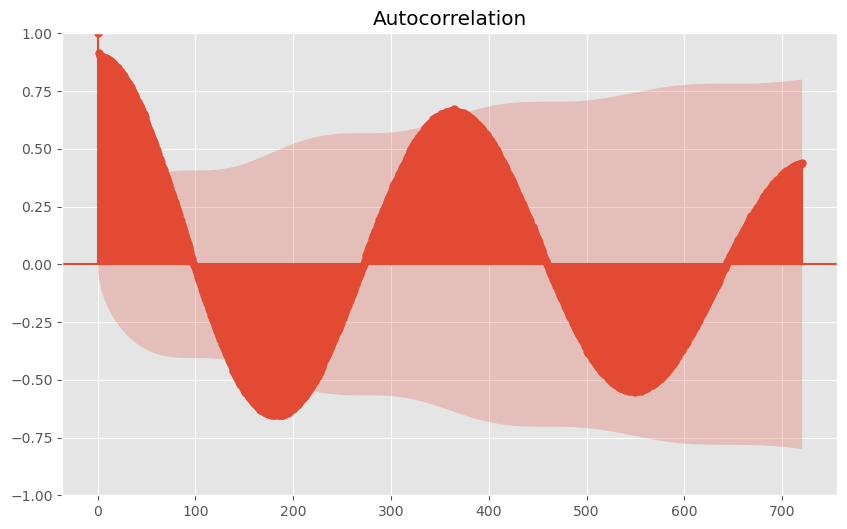

In [5]:
# Examine the time series for autocorrelation and seasonality

# Lag plot - is there evidence of autocorrelation?
lag_value = 730
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title(f'Time Series - Lag Plot')
lag_plot(test_df, lag=lag_value, ax=ax)
plt.show()

# ACF plot  - is there evidence of seasonality?
lag_value = 720
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(test_df, lags=lag_value, ax=ax)
plt.show()


ADF Statistic: -2.413920472380217
p-value: 0.13784594284032065
Critical Value 1%: -3.4339861159726306
Critical Value 5%: -2.863146142843122
Critical Value 10%: -2.5676250581282964
Conclusion: Non-Stationary 



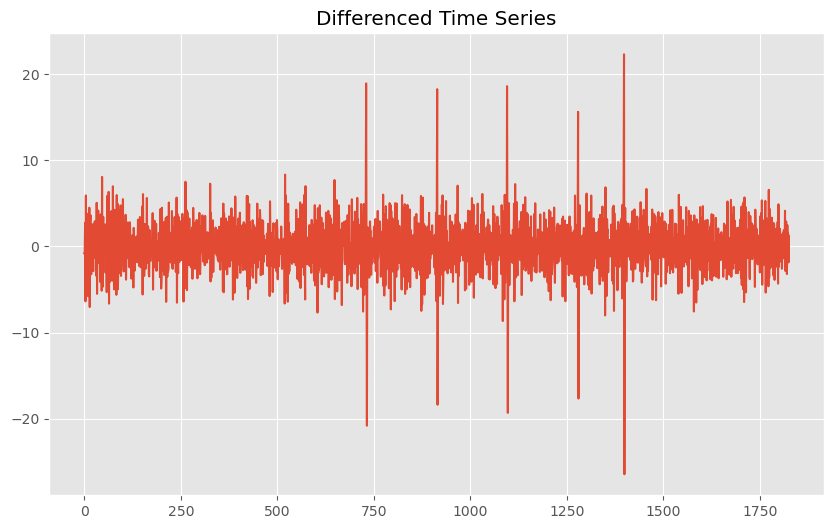

ADF Statistic: -6.9114467379151465
p-value: 1.2094636562602993e-09
Critical Value 1%: -3.4339861159726306
Critical Value 5%: -2.863146142843122
Critical Value 10%: -2.5676250581282964
Conclusion: Stationary 



In [6]:
# Stationarity?
adf_result = adfuller(test_df)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')
print("Conclusion:", "Stationary" if adf_result[1] < 0.05 else "Non-Stationary", "\n")

# Difference the time series to make it stationary
differenced_series = np.diff(test_df['Value'])

fig, ax = plt.subplots(figsize = (10,6))
ax.set_title(f'Differenced Time Series')
ax.plot(differenced_series)
plt.show()

adf_result = adfuller(differenced_series)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')
print("Conclusion:", "Stationary" if adf_result[1] < 0.05 else "Non-Stationary", "\n")


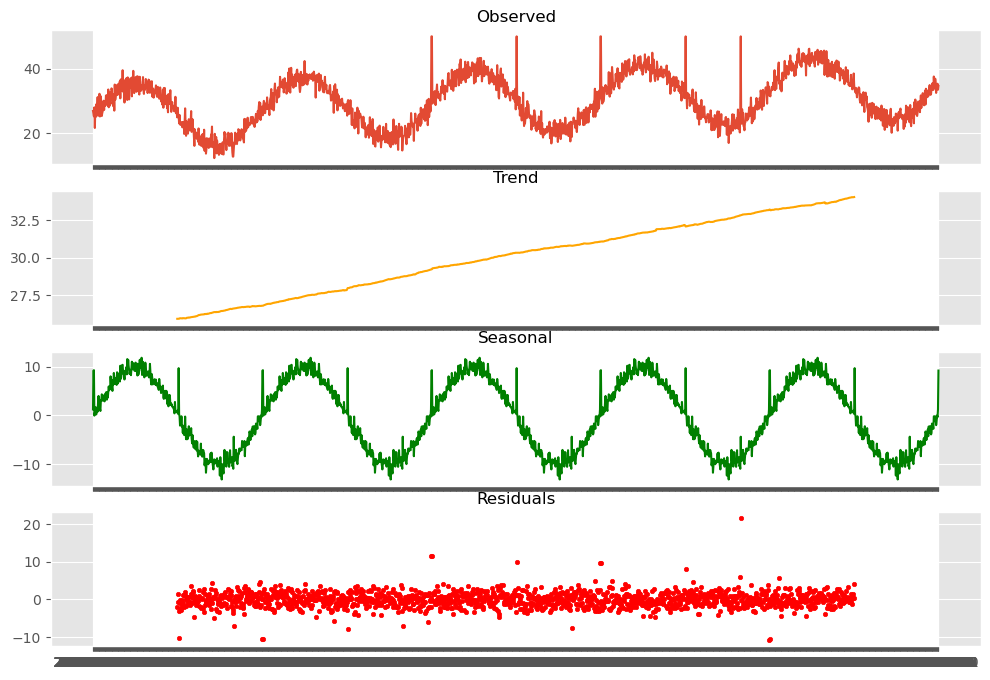

In [7]:
# Decompose the sample
decompose_time_series(test_df)

# OLS Linear Regression

Durbin-Watson statistic: 0.18391808602410195


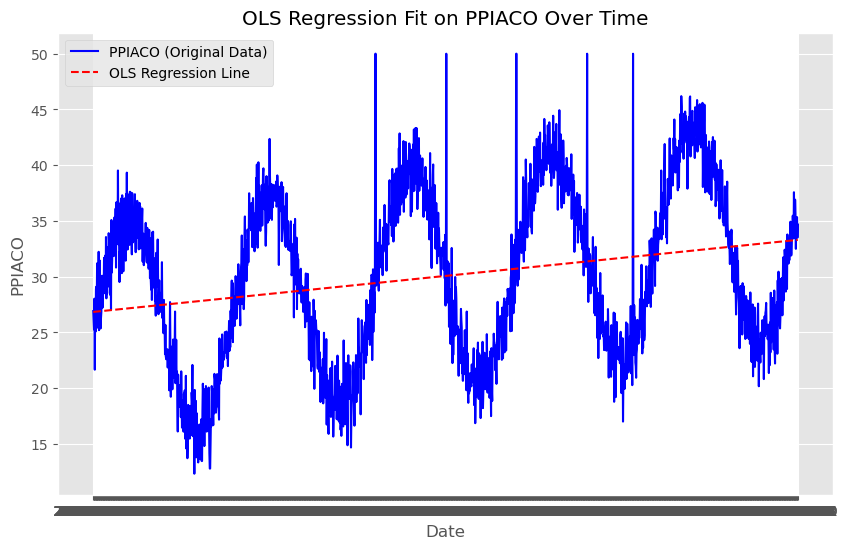

In [17]:
# Fit a linear regression model
x = add_constant(test_df.index.factorize()[0])
y = test_df['Value']
model = OLS(y, x).fit()

# Step 4: Apply the Durbin-Watson test on the residuals
dw_stat = durbin_watson(model.resid)
print("Durbin-Watson statistic:", dw_stat)

# Step 5: Visualize the OLS fit
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['Value'], label='PPIACO (Original Data)', color='blue')
plt.plot(test_df.index, model.fittedvalues, label='OLS Regression Line', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.title('OLS Regression Fit on PPIACO Over Time')
plt.legend()
plt.show()